In [31]:
from __future__ import print_function
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from matplotlib import colors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# Ejercicio 1

Se está diseñando un web service, el cual cada vez que es invocado consulta a una base de datos.
Se estima que el tiempo que transcurre entre cada llamada al servicio se puede modelar según una distribución
exponencial con media μ = 4 segundos. Se debe decidir la arquitectura de base de datos a utilizar entre las dos siguientes:

1) Utilizar 2 bases de datos distribuidas.
Con probabilidad p = 0.6 las solicitudes son atendidas por la base 1 y con probabilidad q = 1 − p son atendidos por
la base de datos 2.
El tiempo que demora cada base de datos en atender una solicitud sigue una distribución exponencial con
medias, μ 1 = 0,7 seg y μ 2 = 1 seg respectivamente.

2) Utilizar 1 base de datos central.
En este caso la demora en resolver una solicitud sigue una distribución exponencial con μ = 0,8 segundos.

Simular para cada opción 100000 solicitudes procesadas, determinando:

 - El tiempo medio de espera entre que la solicitud llega y puede ser procesada (suponer que ninguna conexión se
cae por timeout).

 - La fracción de las solicitudes que no esperaron para ser procesadas.
 
 - La opción 1 es más costosa que la segunda opción y la empresa sólo acepta realizar la inversión si el tiempo medio
que demora en resolver cada solicitud (tiempo en fila + tiempo de procesamiento) es como mínimo 50% menor
que la opción 2. ¿Qué solución le recomienda?

Comenzamos realizando la simulación para 100000 solicitudes procesadas en el escenario en que el tenemos una base de datos distribuida con dos nodos. Se generarán 100000 muestras correspondientes a los tiempos de arribo de las solicitudes según la tasa indicada en el enunciado, que luego serán divididas entre aquellas que son procesadas por la primera base y la segunda.

In [32]:
def simular_procesamiento_base_de_datos(tiempos_de_arribo, media):
    z = np.random.exponential(media, len(tiempos_de_arribo))
    t_actual = 0
    tiempos_de_espera = []
    tiempos_totales_de_procesamiento = []
    for index, t_arribo in enumerate(tiempos_de_arribo):
        if t_arribo < t_actual:
            tiempos_de_espera.append(t_actual - t_arribo)
            t_actual += z[index]
            tiempos_totales_de_procesamiento.append(t_actual - t_arribo + z[index])
        else:
            tiempos_de_espera.append(0)
            t_actual = t_arribo + z[index]
            tiempos_totales_de_procesamiento.append(z[index])
    return sum(tiempos_de_espera) / len(tiempos_de_espera), len([t for t in tiempos_de_espera if t == 0]) / len(tiempos_de_arribo), sum(tiempos_totales_de_procesamiento) / len(tiempos_totales_de_procesamiento)

In [33]:
np.random.seed(32)
media_arribos = 4            
tasa_de_arribo = 1/media_arribos
N = 100000
p = 0.6
media_base_1 = 0.7
media_base_2 = 1

#Generamos N tiempos de arribo.
z = np.random.exponential(1/tasa_de_arribo, N)

#Calculamos los tiempos de arribo.
t = np.concatenate(([0], np.cumsum(z)), axis=None)

#Separamos el proceso segun la base de datos donde sea procesada. Generamos probabilidades aleatorias y las iteramos.
u = np.random.rand(N)

t_base_1 = [0]
t_base_2 = [0]

for i in range(0, N):
    if u[i] < p:
        t_base_1.append(t[i])
    else:
        t_base_2.append(t[i])

tiempo_medio_de_espera_base_1, fraccion_sin_espera_base_1, tiempo_medio_procesamiento_base_1 = simular_procesamiento_base_de_datos(t_base_1, media_base_1)
tiempo_medio_de_espera_base_2, fraccion_sin_espera_base_2, tiempo_medio_procesamiento_base_2 = simular_procesamiento_base_de_datos(t_base_2, media_base_2)

Utilizando un promedio ponderado, calculamos cual es el tiempo medio de entrega y la fracción de solicitudes que no debieron esperar para ser procesadas:

In [34]:
tiempo_promedio_de_espera = (tiempo_medio_de_espera_base_1 * len(t_base_1) + tiempo_medio_de_espera_base_2 * len(t_base_2)) / N
fraccion_sin_espera = fraccion_sin_espera_base_1 * len(t_base_1) / N + fraccion_sin_espera_base_2 * len(t_base_2) / N
tiempo_promedio_de_procesamiento = (tiempo_medio_procesamiento_base_1 * len(t_base_1) + tiempo_medio_procesamiento_base_2 * len(t_base_2)) / N

print("El tiempo medio de espera para una base distribuida con dos nodos es {} segundos.".format(tiempo_promedio_de_espera))
print("La fracción de solicitudes que no deben esperar en caso de que haya una base distribuida con dos nodos es {}.".format(fraccion_sin_espera))
print("El tiempo medio de procesamiento para una solicitud utilizando una base distribuida con dos nodos es {} segundos.".format(tiempo_promedio_de_procesamiento))

El tiempo medio de espera para una base distribuida con dos nodos es 0.09396557408749351 segundos.
La fracción de solicitudes que no deben esperar en caso de que haya una base distribuida con dos nodos es 0.89839.
El tiempo medio de procesamiento para una solicitud utilizando una base distribuida con dos nodos es 1.0006867507267798 segundos.


Ahora, obtengamos las mismas mediciones pero realizando la simulación para el segundo escenario, en donde tenemos una única base de datos centralizada.

In [35]:
np.random.seed(32)
media_arribos = 4            
tasa_de_arribo = 1/media_arribos
N = 100000
media_base = 0.8

#Generamos N tiempos de arribo.
z = np.random.exponential(1/tasa_de_arribo, N)

#Calculamos los tiempos de arribo.
t = np.concatenate(([0], np.cumsum(z)), axis=None)

tiempo_medio_de_espera_base, fraccion_sin_espera_base, tiempo_promedio_de_procesamiento_base = simular_procesamiento_base_de_datos(t, media_base)
print("El tiempo medio de espera para una base centralizada es {} segundos.".format(tiempo_medio_de_espera_base))
print("La fracción de solicitudes que no deben esperar en caso de que haya una base centralizada es {}.".format(fraccion_sin_espera_base))
print("El tiempo medio de procesamiento para una solicitud utilizando una base centralizada es {} segundos.".format(tiempo_promedio_de_procesamiento_base))

El tiempo medio de espera para una base centralizada es 0.2007744701672654 segundos.
La fracción de solicitudes que no deben esperar en caso de que haya una base centralizada es 0.7984520154798452.
El tiempo medio de procesamiento para una solicitud utilizando una base centralizada es 1.1658036051222367 segundos.


Vemos que, en el caso de utilizar una base distribuida con dos nodos a diferencia de una centralizada, hay una disminución del tiempo de procesamiento de una solicitud promedio, pasando de 1.1658036051222367 segundos a 1.0006867507267798 segundos. Sin embargo, esto no es suficiente para cumplir con lo solicitado, una disminución del tiempo del 50% (el tiempo de respuesta promedio de la base distribuida debería estar debajo de 0.5829018025611183 segundos).

Por lo tanto, le recomendaríamos a la empresa que no realice la inversión y mantenga su infraesctructura actual, ya que al realizar al utilizar una base distribuida no se puede cumplir con el tiempo de procesamiento deseado.

# Ejercicio 2

Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).

Se determinó que en 10 milisegundos existe una probabilidad p = 1/40 que llegue una nueva solicitud y una probabilidad q = 1/30 que una solicitud termine de ser procesada y deje el sistema.

Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser procesadas como la solicitud que está siendo procesada.

a. Determine la matriz de transición de estados explicando cómo se obtiene la misma.

b. Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos suponiendo que el servidor comienza sin estar procesando solicitudes.

c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

e. Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

## Respuestas

a) Comenzamos analizando cómo sería la matriz de transiciones entre estados del sistema. Cada estado está representado por la cantidad de solicitudes que hay dentro del sistema, teniendo en cuenta tanto la solicitud que se puede estar procesando como las solicitudes que se encuentram en la cola de espera que se forma en caso de que arribe más de una solicitud al sistema y exista otra que no se haya terminado de procesar.

La matriz, en términos de las probabilidades $p$ y $q$, puede expresarse de la siguiente manera:

P = $\begin{pmatrix}
        1-p           & p                 & 0                 & 0                 & 0                 & 0             & 0 \\
        (1-p) \cdot q & (1-p) \cdot (1-q) & p \cdot (1-q)     & 0                 & 0                 & 0             & 0 \\
        0             & (1-p) \cdot q     & (1-p) \cdot (1-q) & p \cdot (1-q)     & 0                 & 0             & 0 \\
        0             & 0                 & (1-p) \cdot q     & (1-p) \cdot (1-q) & p \cdot (1-q)     & 0             & 0 \\
        0             & 0                 & 0                 & (1-p) \cdot q     & (1-p) \cdot (1-q) & p \cdot (1-q) & 0 \\ 
     \end{pmatrix}$

Notemos que solamente hemos colocado los primeros cinco estados en la matriz. Es evidente que a partir de la misma podemos generalizar las probabilidades de transición para todos los estados posibles, ya que desde un estado $n$ solamente es posible llegar los los estados $n-1$ y $n+1$.

 - La probabilidad de transitar del estado $n$ al $n-1$ es la multiplicación entre la probabilidad de que exista un egreso del sistema y la probabilidad de que no haya un ingreso.

 - La probabilidad de quedarse en el estado $n$ partiendo del estado $n$ es la multiplicación entre la probabilidad de que no exista un ingreso y la probabilidad de que no exista un egreso.

 - La probabilidad de transitar del estado $n$ al $n+1$ es la multiplicación entre la probabilidad de que haya un ingreso al sistema y la probabilidad de no haya un egreso.
 
Esta generalización es valida para todos los $n \geq 1$, ya que para $n=0$ no hay egresos ya que el estado del sistema es vacío. Para este caso, la probabilidad de seguir en el mismo estado $n$ es la probabilidad de que no haya un ingreso, mientras que la probabilidad de pasar al estado $n+1$ es la probabilidad de que haya un ingreso.
 
Matemáticamete, podemos escribir:

- $p_{i, i-1} = (1-p) \cdot q, i \geq 1 $
- $p_{i, i} = (1-p) \cdot (1-q), i \geq 1 $
- $p_{i, i+1} = p \cdot (1-q), i \geq 1  $
- $p_{0, 1} = p $
- $p_{0, 0} = 1-p$
- $p_{i, i-2} = 0$
- $p_{i, i+2} = 0$



b) Notemos que tenemos que hay que simular la evolución del sistemas durante 1000 segundos y nuestro pueden ocurrir transiciones en intervalos de 10 milisegundos, o lo que es lo mismo 0.01 segundos. Realizando la división $\frac{1000s}{0.01s} = 100000$ obtenemos la cantidad de intervalos que debemos simular.

In [36]:
np.random.seed(32)
N = 100000
probabilidad_ingreso = 1/40
probabilidad_egreso = 1/30
probabilidad_n_anterior = (1 - probabilidad_ingreso) * probabilidad_egreso
probabilidad_n_actual = (1 - probabilidad_ingreso) * (1 - probabilidad_egreso)
probabilidad_n_siguiente = probabilidad_ingreso * (1 - probabilidad_egreso)

estados = [0]
estado_actual = 0

p_auxiliares = np.random.rand(N-1)

for i in range(N-1):
    if estado_actual == 0:
        if p_auxiliares[i] <= probabilidad_ingreso:
            estado_actual += 1
    else:
        if p_auxiliares[i] <= probabilidad_n_anterior:
            estado_actual -= 1
        elif p_auxiliares[i] > probabilidad_n_anterior +  probabilidad_n_actual:
            estado_actual += 1
    estados.append(estado_actual)

c) Realizamos el gráfico solicitado en el enunciado, viendo como el sistema transita distintos estados a través del tiempo.

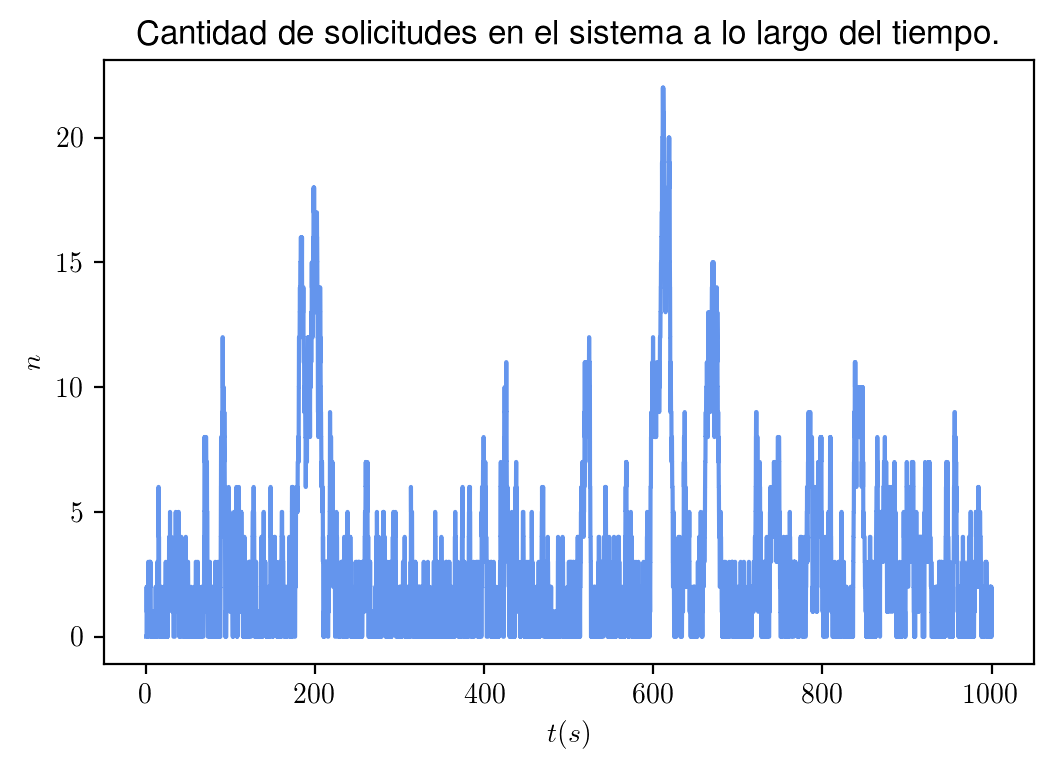

In [37]:
puntos_en_el_tiempo = np.arange(0, 1000, 0.01)
plt.figure(dpi=200)
plt.plot(puntos_en_el_tiempo, estados, color="cornflowerblue")
plt.title("Cantidad de solicitudes en el sistema a lo largo del tiempo.")
plt.xlabel(r"$t(s)$")
plt.ylabel(r"$n$")
plt.show()

d) Realizamos el histograma solicitado:

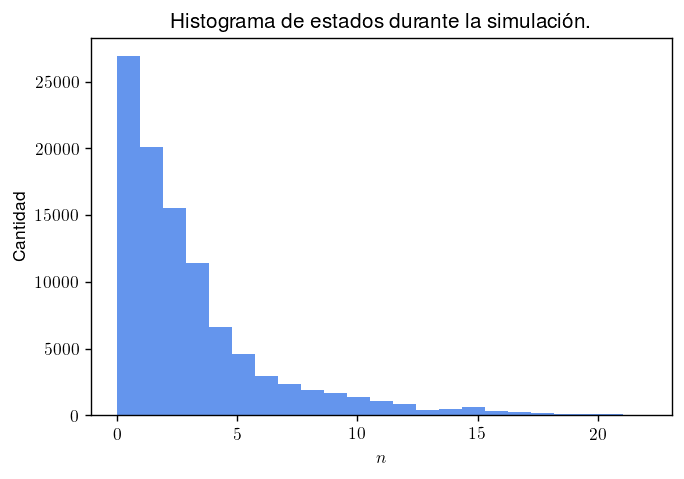

In [38]:
plt.figure(dpi=125)
plt.title('Histograma de estados durante la simulación.')
plt.hist(estados, bins=23, color="cornflowerblue")
plt.ylabel("Cantidad")
plt.xlabel(r"$n$")
plt.show()

Vemos que el histograma generado es similar a una distribución de exponencial decreciente. Esto resulta lógico debido a que la probabilidad de que haya un ingreso es menor a la probabilidad de que haya un egreso, por lo tanto cuando nos encontramos en un estado que es mayor a cero es más posible trasladarse hacia estados más pequeños. -> Ver si sacar esto.

e) Para calcular el tiempo que el servidor se encuentra sin procesar solicitudes, consideramos aquellos momentos donde el estado del sistema es cero, es decir que no hay solicitudes en el sistema, y calculamos que porcentaje total de las muestras ocupan. 

In [39]:
porcentaje_de_muestras_estado_cero = len([e for e in estados if e == 0]) / len(estados) * 100
print("El porcentaje total de tiempo donde el servidor no atiende solicitudes es: {}%.".format(porcentaje_de_muestras_estado_cero))

El porcentaje total de tiempo donde el servidor no atiende solicitudes es: 26.919999999999998%.


# Ejercicio 4

Se desea simular la evolución de una epidemia utilizando el modelo S.I.R.

Se conoce que inicialmente el 3% de la población se encuentra infectada, toda la población es susceptible de
contagiarse, la tasa de transmisión β=0.27, y la tasa de recuperación γ = 0.043.

Se pide:
    
- Implementar el modelo SIR correspondiente.
- Graficar las curvas de porcentajes de personas sanas, infectadas y recuperadas, de forma que se vea la evolución
de la epidemia.
- Sabiendo que el sistema de salud puede asistir cómo máximo sólo al 30% de la población a la vez, determine la
duración total de la epidemia si se quiere que el pico máximo de infectados no supere las capacidades de
asistencia médica. ¿Qué parámetros modifica? ¿Por qué?

El modelo SIR es un tipo de sistema dinámico no linea autónomo de tiempo continuo. Sus variables son las siguientes:

- $S(t)$: Susceptibles de infectarse.
- $I(t)$: Infectacdos.
- $R(t)$: Recuperados.

A partir de estas variables, el modelo SIR  queda definido por las siguientes ecuaciones diferenciales:

- $\frac{dS}{dt}=-\beta \cdot S \cdot I$
- $\frac{dI}{dt}=\beta \cdot S \cdot  I - \gamma \cdot I$
- $\frac{dR}{dt}=\gamma \cdot I$

A su vez, sus parámetros son: 

- Tasa de transmisión: $\beta$
- Tasa de recuperación: $\gamma$


A continuación se encuentra la implementación del modelo SIR. Como nos encontramos con un sistema de ecuaciones diferenciales en tiempo continuo, debemos utilizar un método númerico para realizar la simulación y obtener el valor de las variables a través del tiempo. Elegimos el algoritmo númerico Runge-Kutta de orden 4, que se define de la siguiente manera:

$y = f(x,y)$; $y(x_0) = y_0)$

$y_{i+1} = y_i + \frac{1}{6} \cdot h \cdot (k_1 + 2k_2 + 2k_3 +k_4)$
 
$\left\lbrace\begin{array}{c} k_1 = f(x_i, y_i) \\
                              k_2 = f(x_i + \frac{1}{2} h, y_i +\frac{1}{2}k_1h) \\
                              k_3 = f(x_i + \frac{1}{2} h, y_i +\frac{1}{2}k_2h) \\
                              k_4 = f(x_i + h, y_i + k_3 h)
                              \end{array}\right.$ 
 

In [40]:
def sir_model(x, beta, gamma):
    # x[0] contiene los susceptibles; x[1] contiene a los infectados; x[2] contiene a los recuperados.
    return np.array([-beta * x[0] * x[1], beta * x[0] * x[1] - gamma * x[1], gamma * x[2]])

def simular_sir_con_runge_kutta(x_0, h, tiempo, beta, gamma):
    N = int(tiempo / h)
    tiempos = [0]
    valores = [x_0]
    for i in range(1, N):
        k_1 = sir_model(valores[i-1], beta, gamma)
        k_2 = sir_model(valores[i-1] + 0.5 * k_1 * h, beta, gamma)
        k_3 = sir_model(valores[i-1] + 0.5 * k_2 * h, beta, gamma)
        k_4 = sir_model(valores[i-1] + k_3 * h, beta, gamma)
        valores.append(np.array(valores[i-1] + 1/6 * h * (k_1 + 2*k_2 + 2*k_3 + k_4)))
        tiempos.append(tiempos[i-1] + h)
    return tiempos, valores

In [48]:
s_0 = 0.97
i_0 = 0.03
r_0 = 0.005
h = 0.01

beta = 0.27
gamma = 0.043

tiempos, valores = simular_sir_con_runge_kutta(np.array([s_0, i_0, r_0]), h, 130, beta, gamma)

Procedemos a realizar el gráfico del porcentaje de personas sanas (susceptibles), infectadas y recuperadas a través del tiempo, a fines de determinar la evolución de la epidemia a partir de la simulación realizada.

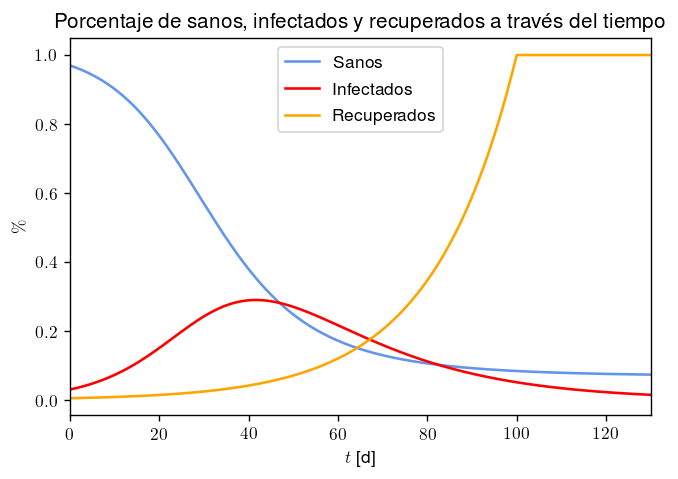

In [53]:
porcentaje_sanos = [valor[0] for valor in valores]
porcentaje_infectados = [valor[1] for valor in valores]
porcentaje_recuperados = [valor[2] if valor[2] < 1 else 1 for valor in valores]
plt.figure(dpi=125)
sanos, = plt.plot(tiempos, porcentaje_sanos, color="cornflowerblue", label="Sanos")
infectados, = plt.plot(tiempos, porcentaje_infectados, color="red", label="Infectados")
recuperados, = plt.plot(tiempos, porcentaje_recuperados, color="orange", label="Recuperados")
plt.title("Porcentaje de sanos, infectados y recuperados a través del tiempo")
plt.xlabel(r"$t$ [d]")
plt.xlim(0,130)
plt.ylabel(r"$\%$")
plt.legend(handles=[sanos, infectados, recuperados])
plt.show()

Analicemos ahora aquellos momentos en los que se ve sobrepasada la capacidad de nuestro sistema de salud. Para esto, grafiquemos únicamente la curva de infectados en conjunto con la capacida del sistema:

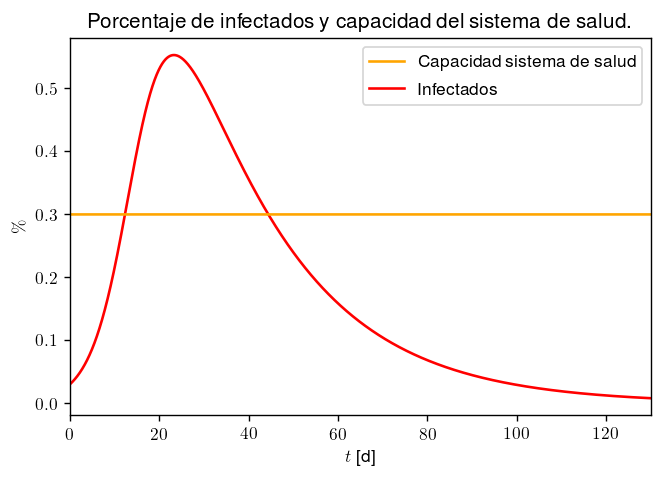

In [50]:
porcentaje_infectados = [valor[1] for valor in valores]
capacidad_sistema = [0.3 for _ in range(len(valores))]
plt.figure(dpi=125)
infectados, = plt.plot(tiempos, porcentaje_infectados, color="red", label="Infectados")
capacidad_sistema, = plt.plot(tiempos, capacidad_sistema, color="orange", label="Capacidad sistema de salud")
plt.title("Porcentaje de infectados y capacidad del sistema de salud.")
plt.xlabel(r"$t$ [d]")
plt.xlim(0,130)
plt.ylabel(r"$\%$")
plt.legend(handles=[capacidad_sistema, infectados])
plt.show()

Vemos que claramente hay un momento de la epidemia donde se sobrepasa el 30% de la población infectada y, por lo tanto, el sistema de salud se ve colapsado. Ahora, intentaremos variar los parámetros beta y gamma de forma tal de poder atravesar la epidemia evitando la saturación del sistema de salud. 

Intuitivamente, podríamos creer que si bajamos la tasa de transimisión y mantenemos estable la tasa de recuperación, podríamos atravesar la epidemia con un pico menos pronunciado.

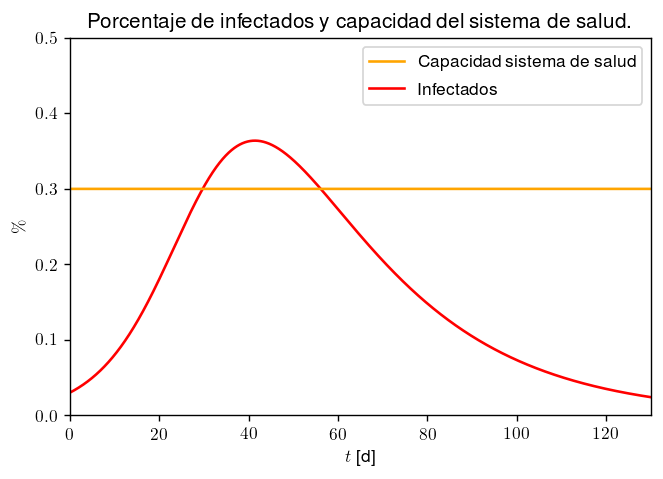

In [51]:
s_0 = 0.97
i_0 = 0.03
r_0 = 0.005
h = 0.01

beta = 0.15
gamma = 0.043

tiempos, valores = simular_sir_con_runge_kutta(np.array([s_0, i_0, r_0]), h, 130, beta, gamma)

porcentaje_infectados = [valor[1] for valor in valores]
capacidad_sistema = [0.3 for _ in range(len(valores))]
plt.figure(dpi=125)
infectados, = plt.plot(tiempos, porcentaje_infectados, color="red", label="Infectados")
capacidad_sistema, = plt.plot(tiempos, capacidad_sistema, color="orange", label="Capacidad sistema de salud")
plt.title("Porcentaje de infectados y capacidad del sistema de salud.")
plt.xlabel(r"$t$ [d]")
plt.xlim(0,130)
plt.ylim(0, 0.5)
plt.ylabel(r"$\%$")
plt.legend(handles=[capacidad_sistema, infectados])
plt.show()

Habiendo disminuido el valor del parámetro $\beta$ a 0.15, vemos que si bien el sistema de salud se sigue saturando, su capacidad de atender a los enfermos apenas se ve superada por el porcentaje de la población infectada. Además, debe notarse que la duración de la epidemia es similar: la diferencia radica en que el pico es menos pronunciado, de forma tal que el crecimiento de la curva de contagios está suavizado y el sistema de salud puede atender mejor a los enfermos.

Ahora, intentemos aumentar la tasa de recuperación. Intuitivamente, es posible pensar que si los enfermos se recuperan más rápido, los hospitales podrán atender a nuevos más rápidamente, ya que los enfermos ocuparán menos tiempos en los hospitales.

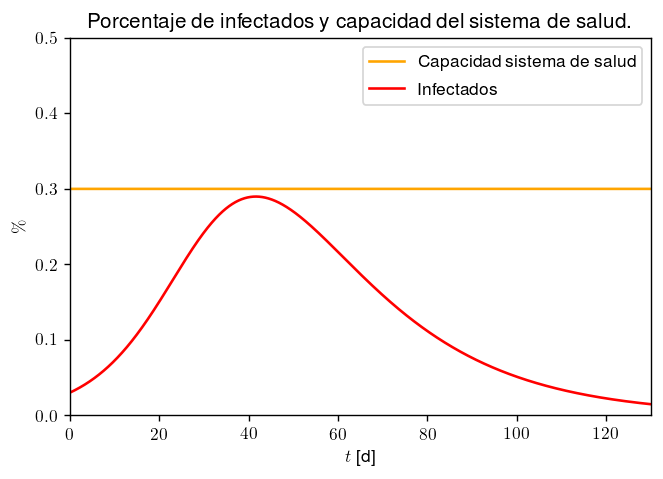

In [52]:
s_0 = 0.97
i_0 = 0.03
r_0 = 0.005
h = 0.01

beta = 0.15
gamma = 0.053

tiempos, valores = simular_sir_con_runge_kutta(np.array([s_0, i_0, r_0]), h, 130, beta, gamma)

porcentaje_infectados = [valor[1] for valor in valores]
capacidad_sistema = [0.3 for _ in range(len(valores))]
plt.figure(dpi=125)
infectados, = plt.plot(tiempos, porcentaje_infectados, color="red", label="Infectados")
capacidad_sistema, = plt.plot(tiempos, capacidad_sistema, color="orange", label="Capacidad sistema de salud")
plt.title("Porcentaje de infectados y capacidad del sistema de salud.")
plt.xlabel(r"$t$ [d]")
plt.xlim(0,130)
plt.ylim(0, 0.5)
plt.ylabel(r"$\%$")
plt.legend(handles=[capacidad_sistema, infectados])
plt.show()

Ahora sí, podemos comprobar que el comportamiento que intuimos era el correcto. Efectivamente, los enfermos se recuperan más rápido y nuestro sistema de salud no se ve colapsado, pudiendo atender a todos los enfermos y salvando la mayor cantidad de vidas posibles.

En conclusión, la variación de los dos parámetros se comportan en la forma opuesta. Por un lado, al disminuir la tasa de transmisión logramos suavizar la curva y los contagiados se reparten espaciadamente a lo largo del tiempo, evitando un pico puntiagudo. En segundo lugar, al aumentar la tasa de recuperación, por ejemplo mediante la utilización de algún medicamento o suero elaborado por el sistema científico, los enfermos pasarán una menor cantidad de tiempo en los hospitales y de esta forma se podrá atender a un mayor cantidad de nuevos contagiados.